# Final Project Submission

Please fill out:
* Student name: Heath Rittler
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: Mark Barbour
* Blog post URL:


My business stakeholder is the owner of a local real estate agency.  The agency
focuses on home improvement recommendations to homeowners that will optimize the 
buying and selling of their homes.  I will be deciphering which home improvements
lead to the most value of a home.

In [2]:
# Importing packages for analysis

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm

plt.style.use('seaborn-talk')

%matplotlib inline

# Data Load, Explore, & Cleaning

## Load

In [3]:
# Here we go!  Read csv, look at initial shape

df = pd.read_csv('data/kc_house_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Because my stakeholder and business proposition is recommending enhancements 
# for homeowners, I am going to remove the features that are not impactable by
# the hoemowner.  (i.e. Homeowner can't change the fact that they are or are not
# on waterfront) removing waterfront, view, lat, long, zipcode

df_clean = df.drop(
    ['waterfront', 'view', 'lat', 'long', 'zipcode'], axis=1)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17755 non-null  float64
 14  sqft_living15  21597 non-null  int64  
 15  sqft_lot15     21597 non-null  int64  
dtypes: float64(4), int64(8), object(4)
memory usage: 2.6+ MB


In [5]:
# Digging into object/ string fields to understand how we will transform.  First
# suspect is sqft_basement, would assume numeric values and 0 for no basement.

df_clean['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2730.0        1
143.0         1
652.0         1
225.0         1
2130.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [6]:
# Changing basement sqft column.  Adjusting ? to 0.0, and changing data type
# to numeric in order to feed model.

df_clean['sqft_basement'] = df_clean['sqft_basement'].replace(['?'],'0.0')

df_clean['sqft_basement'].astype(float)

df_clean['sqft_basement'].value_counts()

0.0       13280
600.0       217
500.0       209
700.0       208
800.0       201
          ...  
143.0         1
2600.0        1
2570.0        1
2390.0        1
417.0         1
Name: sqft_basement, Length: 303, dtype: int64

In [7]:
# Digging into yr_renovated

df_clean['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [8]:
# Not a ton of values, so going to add a boolean feature = is renovated

conditions = [df_clean.loc[:,'yr_renovated'] > 0,
              df_clean.loc[:,'yr_renovated'] == 0]

values = [1,0]

df_clean.loc[:,'is_renovated'] = np.select(conditions, values, default=0)

df_clean['is_renovated'].value_counts()

0    20853
1      744
Name: is_renovated, dtype: int64

In [9]:
# Adding another column with the count of years between yr built and renovation 'yr_frm_btr'

conditions = [
    (df_clean['yr_renovated'] == 0),
    (df_clean['yr_renovated'] > 0)
    ]

# create a list of the values we want to assign for each condition
values = [0, (df_clean['yr_renovated'] - df_clean['yr_built'])]

# create a new column and use np.select to assign values to it using our lists as arguments
df['yr_frm_btr'] = np.select(conditions, values)


In [10]:
# Dropping the yr_renovated column.  Don't necessarily need it right now

df_clean = df_clean.drop('yr_renovated', axis = 1)

In [11]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   grade          21597 non-null  object 
 10  sqft_above     21597 non-null  int64  
 11  sqft_basement  21597 non-null  object 
 12  yr_built       21597 non-null  int64  
 13  sqft_living15  21597 non-null  int64  
 14  sqft_lot15     21597 non-null  int64  
 15  is_renovated   21597 non-null  int64  
dtypes: float64(3), int64(9), object(4)
memory usage: 2.6+ MB


<AxesSubplot:>

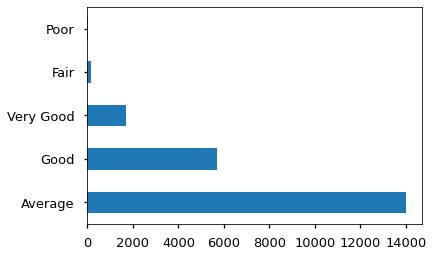

In [12]:
# checking out condition; will need to one hot encode these columns

df_clean['condition'].value_counts().plot(kind='barh')

This breakdown is a little disappointing.  There really isn't a great distribution of condition.  Everything is listed as good, and above.  Going to look at grade to see if that
has a better distribution before encoding.

In [13]:
# checking out grade; going to strip string so we can make column numeric.

df_clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

In [14]:
# split column and add new columns to df
gd_sp = df_clean['grade'].str.split(' ', n = 1, expand = True)

# add column names
gd_sp.columns = ['grade_num', "grade_cat"]

# concat back to df_clean dataframe
df_clean = pd.concat([df_clean, gd_sp], axis = 1)

# update grade_num column to int datatype
df_clean['grade_num'] = df_clean['grade_num'].astype(int)

In [15]:
# dropping original column from dataframe
df_clean = df_clean.drop(['grade'], axis = 1)

# checking df_clean to see where we are at.
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
dtypes: float64(3), int64(10), object(4)
memory usage: 

In [16]:
# Adding some addtional features for fun; ratio of sq_ft above and floors;
# bedrooms amd bathrooms

In [17]:
# Adding ratio of above ground square footage to square footage of living area.  
# Trying to understand if their is more living square footage below ground, 
# is that attractive to a home buyer.

df_clean.loc[:,'sqft_a/l'] = (
    df_clean['sqft_above'] / df_clean['sqft_living']
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000


In [18]:
# Building ratio for living square footage to # of bedrooms.

df_clean.loc[:,'sqft_l/b'] = (
    round(df_clean['sqft_living'] / df_clean['bedrooms'],2)
    )

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated,grade_num,grade_cat,sqft_a/l,sqft_l/b
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,Average,1180,0.0,1955,1340,5650,0,7,Average,1.000000,393.33
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,Average,2170,400.0,1951,1690,7639,1,7,Average,0.844358,856.67
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,Average,770,0.0,1933,2720,8062,0,6,Low Average,1.000000,385.00
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,Very Good,1050,910.0,1965,1360,5000,0,7,Average,0.535714,490.00
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,Average,1680,0.0,1987,1800,7503,0,8,Good,1.000000,560.00


In [19]:
# look for missing data/ na's

df_clean.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
condition        False
sqft_above       False
sqft_basement    False
yr_built         False
sqft_living15    False
sqft_lot15       False
is_renovated     False
grade_num        False
grade_cat        False
sqft_a/l         False
sqft_l/b         False
dtype: bool

In [20]:
# Taking another peek to see what is left to clean or transform

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   condition      21597 non-null  object 
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  sqft_living15  21597 non-null  int64  
 13  sqft_lot15     21597 non-null  int64  
 14  is_renovated   21597 non-null  int64  
 15  grade_num      21597 non-null  int64  
 16  grade_cat      21597 non-null  object 
 17  sqft_a/l       21597 non-null  float64
 18  sqft_l

In [21]:
# OHE categoricals final categoricals

categoricals = ['condition', 'grade_cat']

dummies = pd.get_dummies(df_clean[categoricals], prefix=categoricals, drop_first=True)

df_preprocessed = df_clean.drop(categoricals, axis=1)

df_clean = pd.concat([df_preprocessed, dummies], axis=1)

df_clean.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,1180,0.0,...,0,0,0,0,0,0,0,0,0,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,2170,400.0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,770,0.0,...,0,0,0,0,0,1,0,0,0,0
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,1050,910.0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,1680,0.0,...,0,0,0,1,0,0,0,0,0,0


In [22]:
# Cleaning final sqft_basement column, and dropping the date/ id column for now

df_clean = df_clean.drop('date', axis=1)
df_clean = df_clean.drop('id', axis=1)
df_clean['sqft_basement'] = df_clean['sqft_basement'].astype(float)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price                  21597 non-null  float64
 1   bedrooms               21597 non-null  int64  
 2   bathrooms              21597 non-null  float64
 3   sqft_living            21597 non-null  int64  
 4   sqft_lot               21597 non-null  int64  
 5   floors                 21597 non-null  float64
 6   sqft_above             21597 non-null  int64  
 7   sqft_basement          21597 non-null  float64
 8   yr_built               21597 non-null  int64  
 9   sqft_living15          21597 non-null  int64  
 10  sqft_lot15             21597 non-null  int64  
 11  is_renovated           21597 non-null  int64  
 12  grade_num              21597 non-null  int64  
 13  sqft_a/l               21597 non-null  float64
 14  sqft_l/b               21597 non-null  float64
 15  co

## Initial EDA

In [23]:
# Look at initial distributions of columns

df_clean.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,...,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,285.716581,1970.999676,1986.620318,...,0.121082,0.018475,0.011205,0.280826,0.001250,0.094365,0.004121,0.000602,0.000046,0.052507
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,439.819830,29.375234,685.230472,...,0.326230,0.134664,0.105263,0.449413,0.035337,0.292343,0.064064,0.024528,0.006805,0.223053
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,0.000000,1900.000000,399.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,0.000000,1951.000000,1490.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,0.000000,1975.000000,1840.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,550.000000,1997.000000,2360.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,4820.000000,2015.000000,6210.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Continuous and Categorical additional analysis

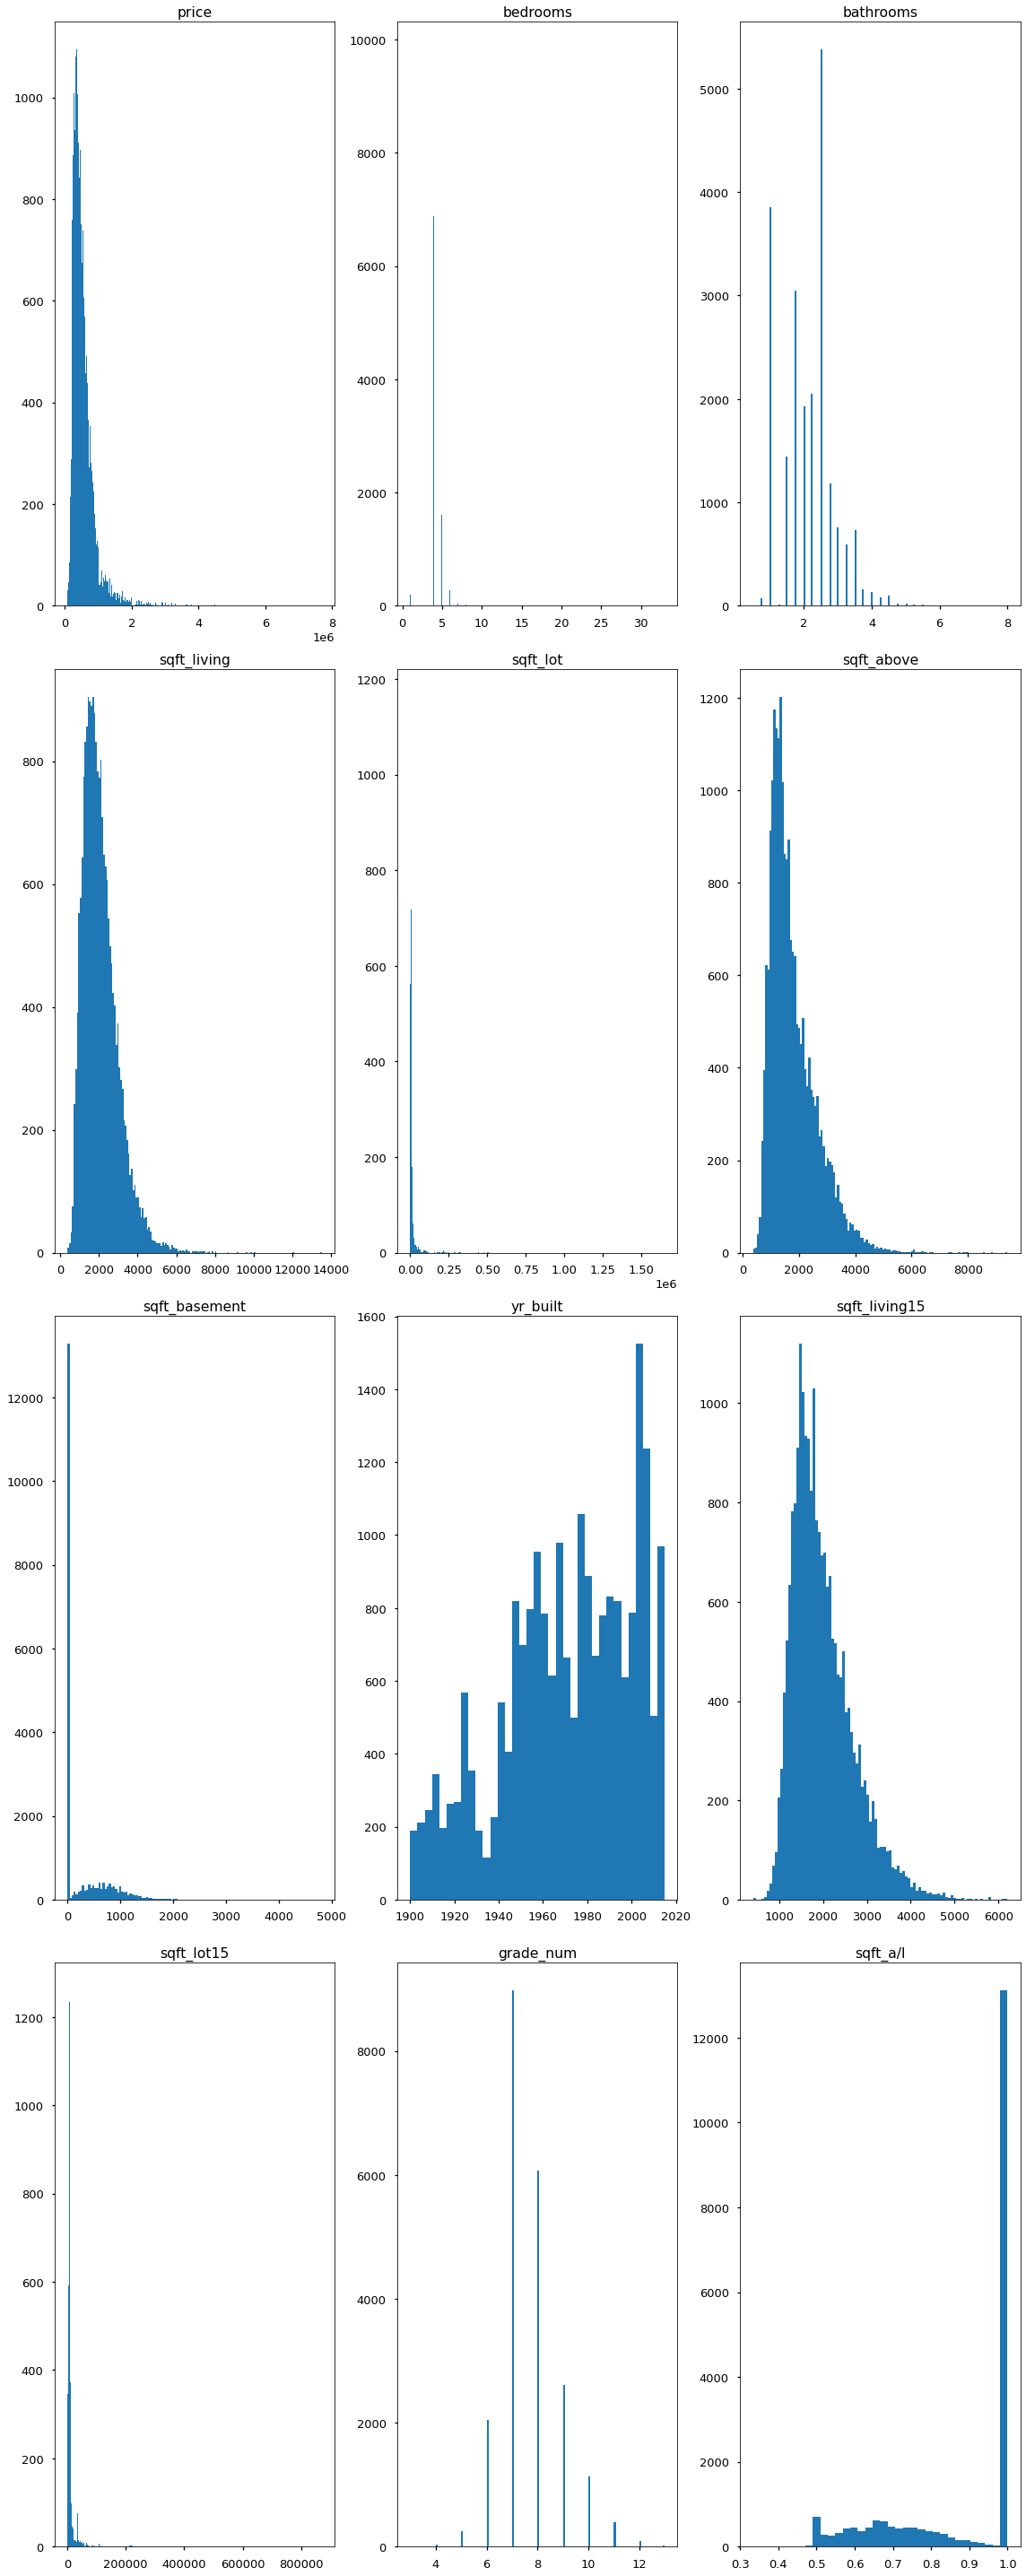

In [24]:
# Identifying the categorical and continuous data by looking at unique values

cat_data = df_clean.loc[:, ((df_clean.dtypes != 'object') & (df_clean.nunique() > 10))]

fig, axes = plt.subplots(nrows=(cat_data.shape[1] // 3), ncols=3, figsize=(16,40))

categoricals = [column for column in cat_data.columns if column != 'Id']

for col, ax in zip(categoricals, axes.flatten()):
    ax.hist(df_clean[col].dropna(), bins='auto')
    ax.set_title(col)
    
fig.tight_layout()

In [25]:
categoricals

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'sqft_living15',
 'sqft_lot15',
 'grade_num',
 'sqft_a/l',
 'sqft_l/b']

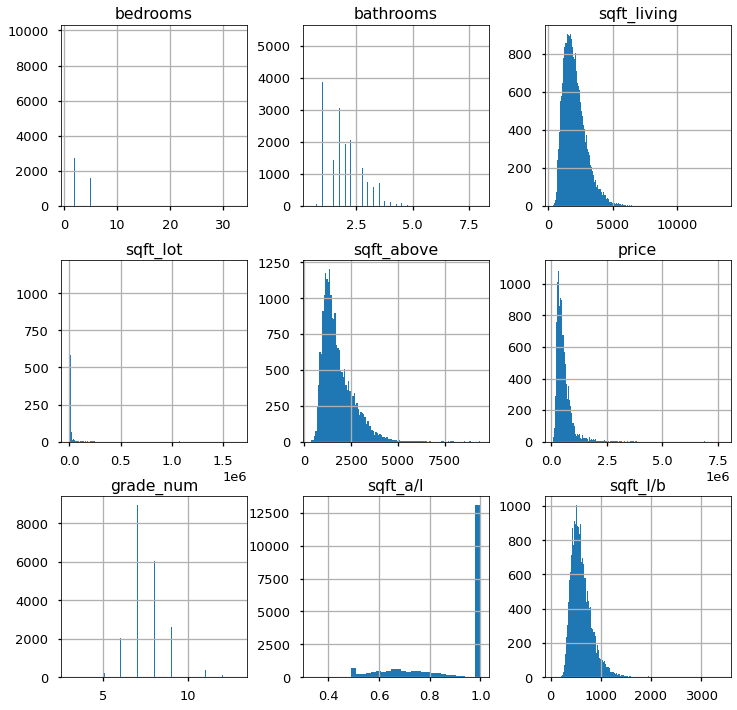

In [26]:
# Select non zero-inflated continuous features
continuous = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
              'sqft_above', 'price', 'grade_num', 'sqft_a/l', 
              'sqft_l/b']
cont = df_clean[continuous]
cont.hist(figsize  = [12, 12], bins='auto');

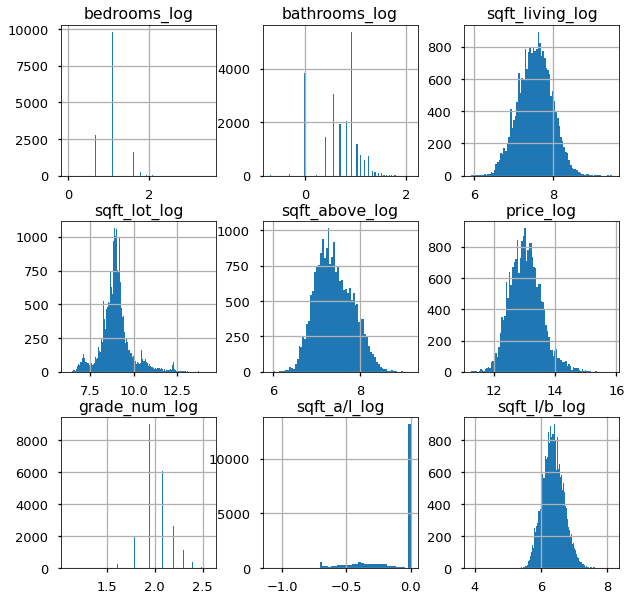

In [27]:
df_log = [f'{column}_log' for column in cont.columns]

log = np.log(cont)
log.columns = df_log
log.hist(figsize=(10, 10), bins='auto')
fig.tight_layout();

array([[<AxesSubplot:title={'center':'bedrooms_log'}>,
        <AxesSubplot:title={'center':'bathrooms_log'}>,
        <AxesSubplot:title={'center':'sqft_living_log'}>],
       [<AxesSubplot:title={'center':'sqft_lot_log'}>,
        <AxesSubplot:title={'center':'sqft_above_log'}>,
        <AxesSubplot:title={'center':'price_log'}>],
       [<AxesSubplot:title={'center':'grade_num_log'}>,
        <AxesSubplot:title={'center':'sqft_a/l_log'}>,
        <AxesSubplot:title={'center':'sqft_l/b_log'}>]], dtype=object)

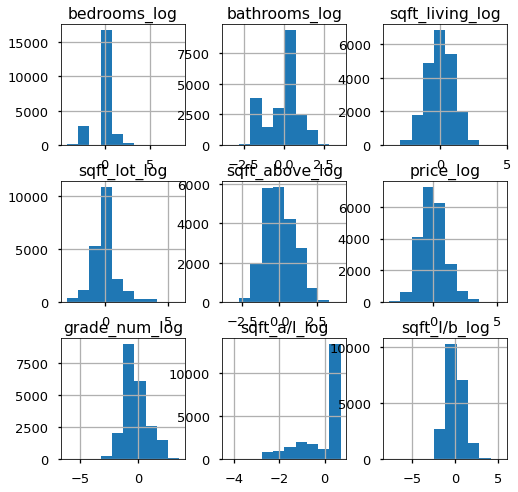

In [28]:
# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

log_norm = log.apply(normalize)

log_norm.hist(figsize = [8,8])

In [29]:
df_final = pd.concat([log_norm, df_clean], axis = 1)
df_final

,bedrooms_log,bathrooms_log,sqft_living_log,sqft_lot_log,sqft_above_log,price_log,grade_num_log,sqft_a/l_log,sqft_l/b_log,price,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
0,-0.279718,-1.726509,-1.125556,-0.388430,-0.753565,-1.401998,-0.525931,0.703255,-1.232436,221900.0,...,0,0,0,0,0,0,0,0,0,0
1,-0.279718,0.339653,0.709446,-0.113241,0.672693,0.279938,-0.525931,-0.061506,1.176422,538000.0,...,0,0,0,0,0,0,0,0,0,0
2,-1.711611,-1.726509,-2.131893,0.244475,-1.752954,-1.799430,-1.558109,0.703255,-1.298678,180000.0,...,0,0,0,0,0,1,0,0,0,0
3,0.736226,1.072635,0.070674,-0.523914,-1.026835,0.499698,-0.525931,-2.118193,-0.552375,604000.0,...,0,0,0,0,0,0,0,0,0,0
4,-0.279718,0.039555,-0.292725,0.008139,0.073515,0.178434,0.368181,0.703255,-0.139147,510000.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,-0.279718,0.608100,-0.513206,-2.171594,-0.145444,-0.483049,0.368181,0.703255,-0.428574,360000.0,...,0,0,0,1,0,0,0,0,0,0
21593,0.736226,0.608100,0.458007,-0.356901,0.819063,-0.282955,0.368181,0.703255,-0.043921,400000.0,...,0,0,0,1,0,0,0,0,0,0
21594,-1.711611,-2.459491,-1.469061,-1.975378,-1.094699,-0.273005,-0.525931,0.703255,-0.428574,402101.0,...,0,0,0,0,0,0,0,0,0,0
21595,-0.279718,0.608100,-0.407744,-1.343114,-0.040710,-0.282955,0.368181,0.703255,-0.290153,400000.0,...,0,0,0,1,0,0,0,0,0,0


In [32]:
# create predictors
predictors = df_final.drop(['price', 'price_log'], axis=1)

# create model intercept
predictors_int = sm.add_constant(predictors)

# fit model to data
model = sm.OLS(df_final['price'],predictors_int).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     1327.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:48:04   Log-Likelihood:            -2.9542e+05
No. Observations:               21597   AIC:                         5.909e+05
Df Residuals:                   21563   BIC:                         5.912e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.695e+05   5.52e+04     12.128      0.000    5.61e+05    7.78e+05
bedrooms_log          -6.101e+07   1.12e+08     -0.545      0.585    -2.8e+08    1.58e+08
bathrooms_log          -4.74e+04   8089.166     -5.859      0.000   -6.33e+04   -3.15e+04
sqft_living_log        5.132e+07   9.42e+07      0.545      0.586   -1.33e+08    2.36e+08
sqft_lot_log          -3.982e+04   2620.515    -15.195      0.000    -4.5e+04   -3.47e+04
sqft_above_log         4.026e+07   7.38e+07      0.546      0.585   -1.04e+08    1.85e+08
grade_num_log         -6.514e+05   2.56e+04    -25.397      0.000   -7.02e+05   -6.01e+05
sqft_a/l_log          -2.067e+07   3.82e+07     -0.541      0.589   -9.56e+07    5.43e+07
sqft_l/b_log          -6.967e+07   1.28e+08     -0.546      0.585    -3.2e+08     1.8e+08
bedrooms              -2.591e+04   5830.988     -4.443      0.000   -3.73e+04   -1.45e+04
bathrooms              1.071e+05   1.05e+04     10.173      0.000    8.65e+04    1.28e+05
sqft_living             260.7820     21.616     12.064      0.000     218.413     303.151
sqft_lot                  0.3390      0.055      6.144      0.000       0.231       0.447
floors                 1.959e+04   4332.450      4.521      0.000    1.11e+04    2.81e+04
sqft_above              -52.6434     21.702     -2.426      0.015     -95.181     -10.106
sqft_basement            59.2457     18.799      3.152      0.002      22.398      96.093
yr_built              -3181.8973     71.325    -44.611      0.000   -3321.700   -3042.095
sqft_living15            65.9789      3.619     18.229      0.000      58.885      73.073
sqft_lot15               -0.1403      0.081     -1.740      0.082      -0.298       0.018
is_renovated           7.837e+04   8352.135      9.383      0.000     6.2e+04    9.47e+04
grade_num              7.933e+05   1.92e+04     41.308      0.000    7.56e+05    8.31e+05
sqft_a/l              -8.766e+05   1.07e+05     -8.166      0.000   -1.09e+06   -6.66e+05
sqft_l/b                245.4826     33.338      7.364      0.000     180.139     310.827
condition_Fair        -2.563e+04   1.65e+04     -1.552      0.121    -5.8e+04    6735.586
condition_Good         3.292e+04   3638.715      9.047      0.000    2.58e+04    4.01e+04
condition_Poor        -1.389e+04   3.96e+04     -0.350      0.726   -9.15e+04    6.38e+04
condition_Very Good    7.428e+04   5857.558     12.681      0.000    6.28e+04    8.58e+04
grade_cat_Better      -2.674e+05      2e+04    -13.390      0.000   -3.07e+05   -2.28e+05
grade_cat_Excellent   -6.037e+05   3.69e+04    -16.353      0.000   -6.76e+05   -5.31e+05
grade_cat_Fair        -6.107e+04   3.23e+04     -1.889      0.059   -1.24e+05    2293.863
grade_cat_Good        -1.183e+05   1.11e+04    -10.692      0.000    -1.4e+05   -9.66e+04
grade_cat_Low         -

In [34]:
# create predictors
predictors = log_norm.drop(['price_log'], axis=1)

# create model intercept
predictors_int = sm.add_constant(predictors)

# fit model to data
model = sm.OLS(log_norm['price_log'],predictors_int).fit()

In [35]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     3836.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        17:51:06   Log-Likelihood:                -21917.
No. Observations:               21597   AIC:                         4.385e+04
Df Residuals:                   21589   BIC:                         4.391e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.343e-15      0.005   2.96e-13      1.000      -0.009       0.009
bedrooms_log     -245.2195    353.365     -0.694      0.488    -937.840     447.401
bathrooms_log      -0.0858      0.007    -11.525      0.000      -0.100      -0.071
sqft_living_log   206.8479    297.779      0.695      0.487    -376.822     790.518
sqft_lot_log       -0.0632      0.005    -12.540      0.000      -0.073      -0.053
sqft_above_log    161.9432    233.179      0.695      0.487    -295.105     618.991
grade_num_log       0.4483      0.007     60.505      0.000       0.434       0.463
sqft_a/l_log      -83.9469    120.764     -0.695      0.487    -320.654     152.760
sqft_l/b_log     -279.7304    403.250     -0.694      0.488   -1070.129     510.669
==============================================================================
Omnibus:                      123.176   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.269
Skew:                           0.176   Prob(JB):                     3.81e-28
Kurtosis:                       3.127   Cond. No.                     4.69e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.14e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [41]:
df_og_cats = df_clean.iloc[:, 0:12]

df_og_cats

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,is_renovated
0,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,1340,5650,0
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1690,7639,1
2,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,2720,8062,0
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,1360,5000,0
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,1800,7503,0
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,1530,1509,0
21593,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,1830,7200,0
21594,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,1020,2007,0
21595,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,1410,1287,0


In [38]:
# create predictors
predictors = df_og_cats.drop(['price'], axis=1)

# create model intercept
predictors_int = sm.add_constant(predictors)

# fit model to data
model = sm.OLS(df_og_cats['price'],predictors_int).fit()

In [39]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     2601.
Date:                Mon, 26 Sep 2022   Prob (F-statistic):               0.00
Time:                        18:02:03   Log-Likelihood:            -2.9828e+05
No. Observations:               21597   AIC:                         5.966e+05
Df Residuals:                   21585   BIC:                         5.967e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.666e+06   1.41e+05     47.225      0.000    6.39e+06    6.94e+06
bedrooms      -6.549e+04   2227.096    -29.405      0.000   -6.99e+04   -6.11e+04
bathrooms      6.708e+04   3880.326     17.288      0.000    5.95e+04    7.47e+04
sqft_living     205.6624     21.566      9.537      0.000     163.392     247.933
sqft_lot          0.0202      0.057      0.353      0.724      -0.092       0.132
floors         5.822e+04   4165.821     13.976      0.000    5.01e+04    6.64e+04
sqft_above       42.1670     21.572      1.955      0.051      -0.115      84.449
sqft_basement    53.9596     21.434      2.518      0.012      11.948      95.971
yr_built      -3466.0878     73.334    -47.265      0.000   -3609.827   -3322.348
sqft_living15    93.6687      3.808     24.598      0.000      86.205     101.133
sqft_lot15       -0.7013      0.087     -8.030      0.000      -0.872      -0.530
is_renovated   5.077e+04   9360.898      5.424      0.000    3.24e+04    6.91e+04
==============================================================================
Omnibus:                    15502.669   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           718564.494
Skew:                           2.943   Prob(JB):                         0.00
Kurtosis:                      30.638   Cond. No.                     4.35e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.35e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Archive

### Correlation Matrix & Colinearity

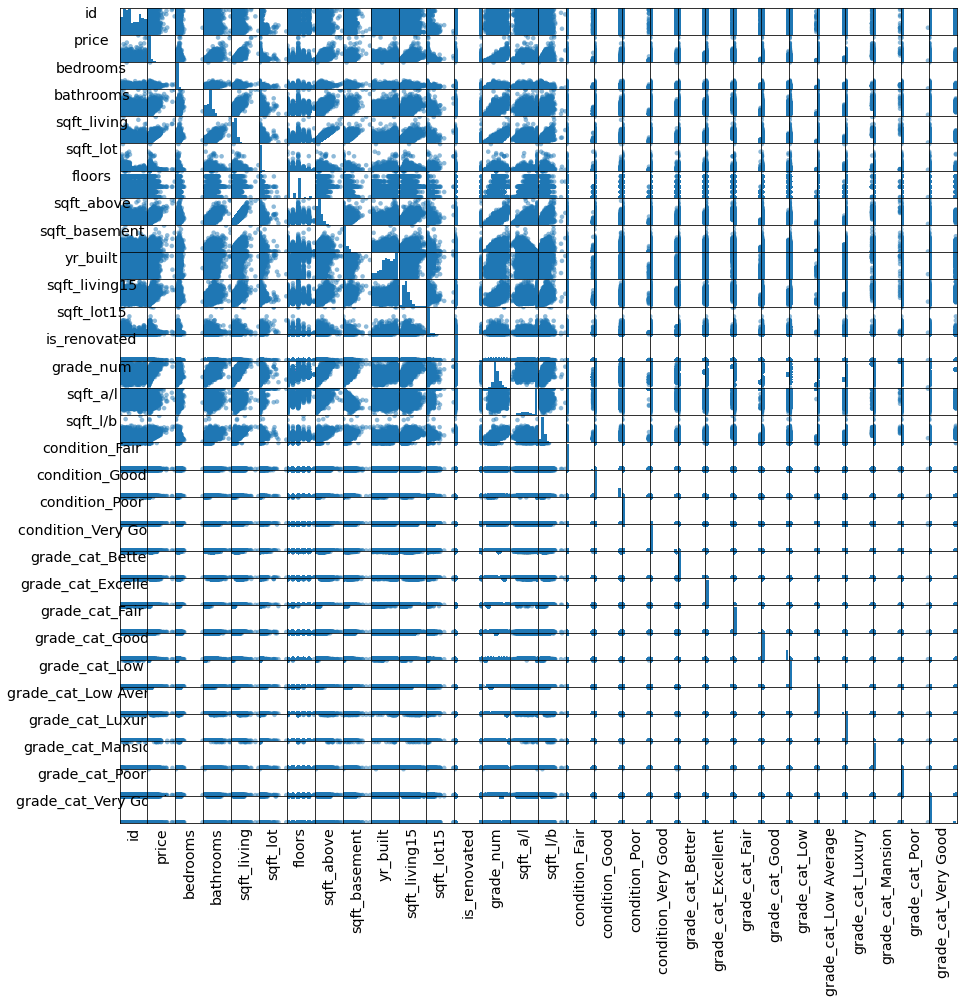

In [34]:
sm = pd.plotting.scatter_matrix(df_clean, figsize = [15,15]);

# Rotates the text
[s.xaxis.label.set_rotation(90) for s in sm.reshape(-1)]
[s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]

#May need to offset label when rotating to prevent overlap of figure
[s.get_yaxis().set_label_coords(-1,0.5) for s in sm.reshape(-1)]

#Hide all ticks
[s.set_xticks(()) for s in sm.reshape(-1)]
[s.set_yticks(()) for s in sm.reshape(-1)]

plt.show()

In [35]:
df_clean.corr()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.010799,-0.004359,0.021617,...,0.009121,-0.019837,-0.025640,0.042285,-0.002903,-0.015476,-0.015084,-0.003880,-0.005110,-0.014390
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.605368,0.321108,0.053953,...,0.235859,0.357589,-0.084549,0.004576,-0.031618,-0.209463,0.291068,0.211806,-0.005155,0.340944
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,0.479386,0.297229,0.155670,...,0.160294,0.116596,-0.113175,0.073140,-0.068012,-0.239492,0.062257,0.039026,-0.017434,0.135766
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.686668,0.278485,0.507173,...,0.264756,0.247293,-0.138740,0.189426,-0.055599,-0.366185,0.159734,0.095118,-0.012087,0.272635
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.876448,0.428660,0.318152,...,0.318499,0.345964,-0.127198,0.071115,-0.053935,-0.312486,0.238136,0.144424,-0.011565,0.369228
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.184139,0.015031,0.052946,...,0.049646,0.077104,0.022931,-0.023923,0.000440,-0.019116,0.061699,0.007767,-0.000348,0.074421
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.523989,-0.241866,0.489193,...,0.244184,0.118735,-0.080346,0.201188,-0.029964,-0.230529,0.054276,0.021257,-0.006230,0.173943
sqft_above,-0.010799,0.605368,0.479386,0.686668,0.876448,0.184139,0.523989,1.000000,-0.051175,0.424037,...,0.343388,0.342198,-0.108543,0.059423,-0.047669,-0.280761,0.222177,0.126666,-0.010429,0.376399
sqft_basement,-0.004359,0.321108,0.297229,0.278485,0.428660,0.015031,-0.241866,-0.051175,1.000000,-0.130085,...,0.017906,0.076299,-0.059784,0.035518,-0.022388,-0.120907,0.079831,0.063423,-0.004421,0.060511
yr_built,0.021617,0.053953,0.155670,0.507173,0.318152,0.052946,0.489193,0.424037,-0.130085,1.000000,...,0.220104,0.098762,-0.128815,0.199844,-0.041843,-0.313501,0.046874,0.004692,-0.011814,0.148820


In [36]:
abs(df_clean.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_above,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_basement,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
yr_built,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [37]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=df_clean.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#drop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)

In [38]:
df[(df.cc >.75) & (df.cc <1)]

,cc
pairs,
"(sqft_a/l, sqft_basement)",0.899093
"(sqft_living, sqft_above)",0.876448
"(sqft_living, grade_num)",0.762779
"(sqft_living, sqft_living15)",0.756402
"(sqft_above, grade_num)",0.756073
"(sqft_living, bathrooms)",0.755758
"(sqft_l/b, sqft_living)",0.755398


In [ ]:
# if there is high colinearity we will want to drop at least one column
# from each pair, or the column that shows up repeatedly.

In [ ]:
final_df = ames_preprocessed.drop(['GarageArea', 'GrLivArea', 'TotalBsmtSF'], axis=1)
final_df.shape

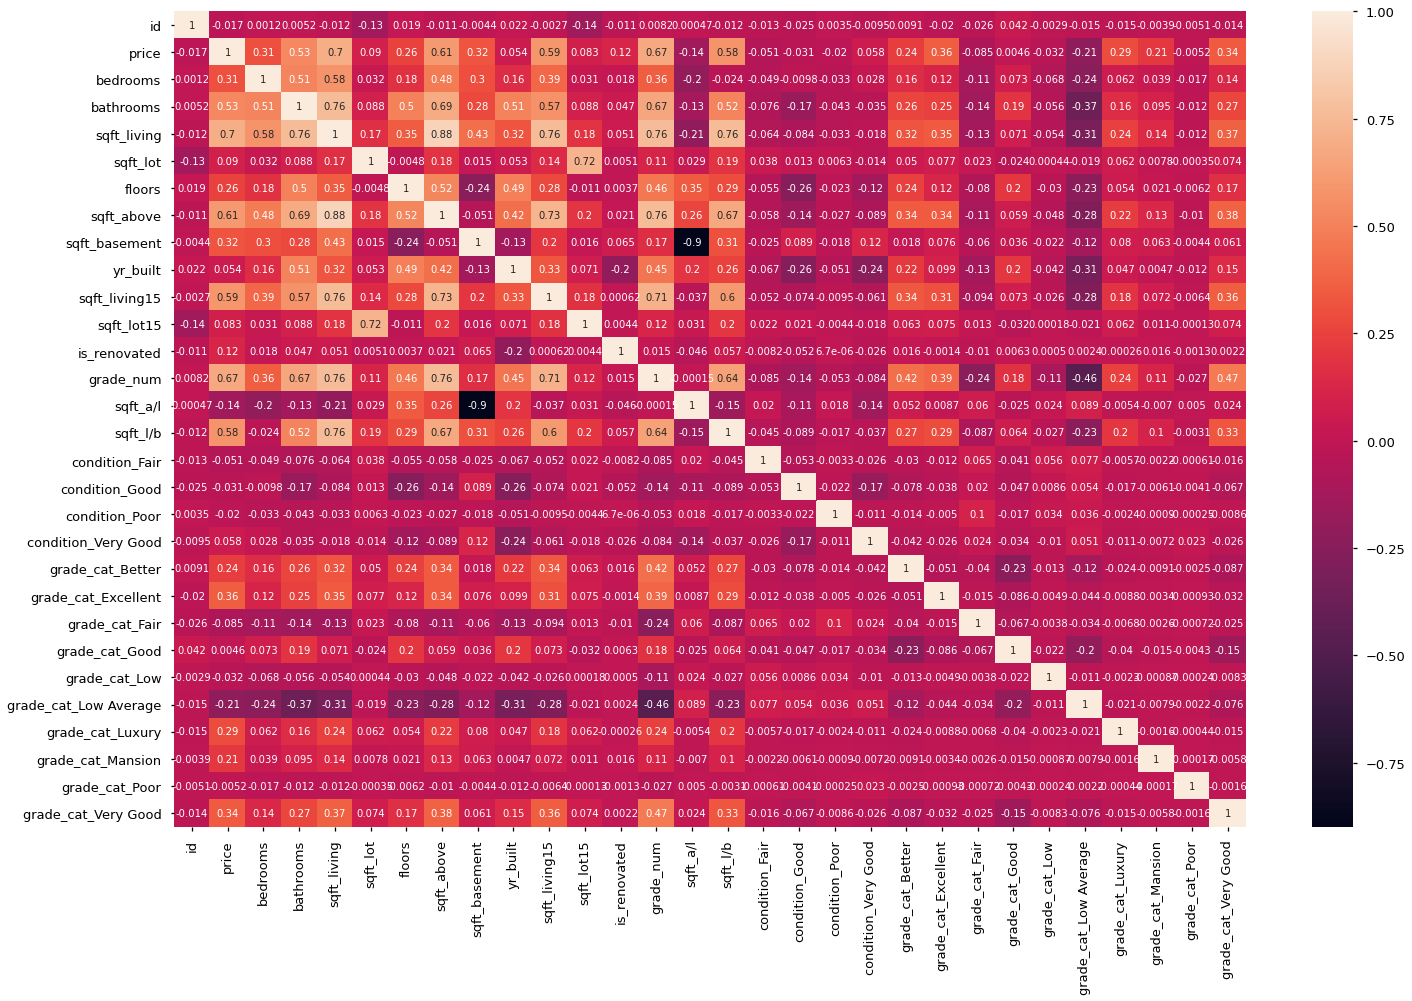

In [39]:
plt.figure(figsize = (24,15))
corrM = df_clean.corr()

sns.heatmap(corrM, annot=True)
plt.show()

## Regression Modeling

In [23]:
# create predictors
predictors = df_clean.drop(['price'], axis=1)

# create model intercept
predictors_int = sm.add_constant(predictors)

# fit model to data
model = sm.OLS(df_clean['price'],predictors_int).fit()


In [25]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                     1471.
Date:                Wed, 21 Sep 2022   Prob (F-statistic):               0.00
Time:                        10:38:25   Log-Likelihood:            -2.9586e+05
No. Observations:               21597   AIC:                         5.918e+05
Df Residuals:                   21568   BIC:                         5.920e+05
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  3.542e+06   1.09e+05     32.596      0.000    3.33e+06    3.76e+06
id                     -1.03e-06   5.16e-07     -1.994      0.046   -2.04e-06   -1.76e-08
bedrooms              -4.463e+04   4117.859    -10.839      0.000   -5.27e+04   -3.66e+04
bathrooms              5.219e+04   3526.658     14.799      0.000    4.53e+04    5.91e+04
sqft_living             263.9992     21.548     12.252      0.000     221.764     306.234
sqft_lot                  0.0081      0.051      0.159      0.874      -0.092       0.109
floors                 4.683e+04   3863.708     12.122      0.000    3.93e+04    5.44e+04
sqft_above             -141.9674     21.588     -6.576      0.000    -184.281     -99.654
sqft_basement            52.2622     19.178      2.725      0.006      14.671      89.853
yr_built              -3394.6472     71.442    -47.516      0.000   -3534.679   -3254.615
sqft_living15            45.0450      3.606     12.493      0.000      37.978      52.112
sqft_lot15               -0.5291      0.078     -6.746      0.000      -0.683      -0.375
is_renovated           6.832e+04   8510.788      8.027      0.000    5.16e+04     8.5e+04
grade_num              4.164e+05   8207.763     50.733      0.000       4e+05    4.32e+05
sqft_a/l               3.536e+05   2.56e+04     13.820      0.000    3.03e+05    4.04e+05
sqft_l/b                -79.8235     21.525     -3.708      0.000    -122.014     -37.633
condition_Fair        -3.079e+04   1.68e+04     -1.829      0.067   -6.38e+04    2204.835
condition_Good         2.072e+04   3680.908      5.628      0.000    1.35e+04    2.79e+04
condition_Poor        -3.033e+04   4.04e+04     -0.750      0.453    -1.1e+05    4.89e+04
condition_Very Good    6.199e+04   5938.825     10.438      0.000    5.03e+04    7.36e+04
grade_cat_Better      -6.034e+05   1.64e+04    -36.710      0.000   -6.36e+05   -5.71e+05
grade_cat_Excellent   -9.669e+05   3.38e+04    -28.576      0.000   -1.03e+06   -9.01e+05
grade_cat_Fair         6.925e+05   2.07e+04     33.401      0.000    6.52e+05    7.33e+05
grade_cat_Good        -3.303e+05   8561.329    -38.585      0.000   -3.47e+05   -3.14e+05
grade_cat_Low          1.094e+06    4.6e+04     23.795      0.000       1e+06    1.18e+06
grade_cat_Low Average  3.319e+05   9241.588     35.914      0.000    3.14e+05     3.5e+05
grade_cat_Luxury      -8.758e+05    4.5e+04    -19.441      0.000   -9.64e+05   -7.88e+05
grade_cat_Mansion     -2.118e+05   6.81e+04     -3.112      0.002   -3.45e+05   -7.84e+04
grade_cat_Poor         1.458e+06   1.97e+05      7.402      0.000    1.07e+06    1.84e+06
grade_cat_Very Good   -8.313e+05   2.48e+04    -33.461      0.000    -8.8e+05   -7.83e+05
==============================================================================
Omnibus:                    14218.

Realizing that I might have too many independent variables.  Going to start visualizing the data, and understanding what might have better performance vs those that do not.

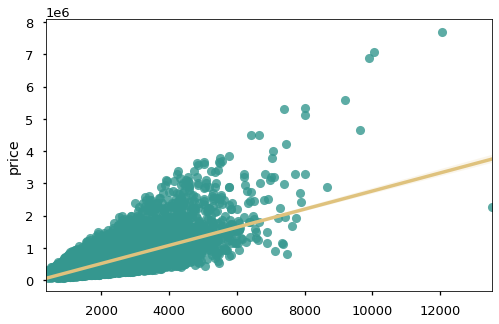

In [27]:
#sns.scatterplot(data=mdo_clean, x='return', y='total_box_office')

plt.figure(figsize = (8,5))

rp = sns.regplot(x='sqft_living',
            y='price', 
            data=df_clean,
            scatter_kws={"color": '#35978f'}, 
            line_kws={"color": '#dfc27d'})

rp.set_ylabel('price')
rp.set_xlabel('')
rp.set_title('');

In [28]:
df_clean.drop('id', axis=1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,yr_built,sqft_living15,...,grade_cat_Better,grade_cat_Excellent,grade_cat_Fair,grade_cat_Good,grade_cat_Low,grade_cat_Low Average,grade_cat_Luxury,grade_cat_Mansion,grade_cat_Poor,grade_cat_Very Good
0,221900.0,3,1.00,1180,5650,1.0,1180,0.0,1955,1340,...,0,0,0,0,0,0,0,0,0,0
1,538000.0,3,2.25,2570,7242,2.0,2170,400.0,1951,1690,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,2,1.00,770,10000,1.0,770,0.0,1933,2720,...,0,0,0,0,0,1,0,0,0,0
3,604000.0,4,3.00,1960,5000,1.0,1050,910.0,1965,1360,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,3,2.00,1680,8080,1.0,1680,0.0,1987,1800,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,1530,0.0,2009,1530,...,0,0,0,1,0,0,0,0,0,0
21593,400000.0,4,2.50,2310,5813,2.0,2310,0.0,2014,1830,...,0,0,0,1,0,0,0,0,0,0
21594,402101.0,2,0.75,1020,1350,2.0,1020,0.0,2009,1020,...,0,0,0,0,0,0,0,0,0,0
21595,400000.0,3,2.50,1600,2388,2.0,1600,0.0,2004,1410,...,0,0,0,1,0,0,0,0,0,0


# Notes

Figure out the range of grade?  What are the average ranges of each grade?

Remove outliers!

Remove p-values of > .05

qq plot
